In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import sys
from os.path import abspath
sys.path.insert(0, abspath('..'))

from os.path import join

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from spherecluster import SphericalKMeans, VonMisesFisherMixture
import numpy as np


import torch
from torchSTC.data import load_data
from torchSTC.modules import STC
from torchSTC.metrics import SpacePlot, Evaluate
from torchSTC.utils.cluster import SphericalKmeans

plot = SpacePlot()
eval = Evaluate()

[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


>>>>> /home/godwin/Documents/academic/PPD/torchSTC/demos/stackoverlow
>>>>> data_loader.py cwd:  /home/godwin/Documents/academic/PPD/torchSTC/demos/stackoverlow


/home/godwin/Documents/academic/PPD/torchSTC/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
cur = abspath("")
dataset = 'stackoverflow'
data_in_dir=join(cur, "../..", "datasets")
dataset_dir=join(data_in_dir, dataset)

In [7]:
checkpoint_dir=join(dataset_dir, 
                    "artefacts",
                    "STC-d384:500:500:2000:20-epoch30-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeNone-norml2-initKmeans"
                    )

checkpoint = "STC-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeNone-norml2-initKmeans.pth"
checkpoint_path = join(checkpoint_dir, checkpoint)
checkpoint_path

'/home/godwin/Documents/academic/PPD/torchSTC/demos/stackoverlow/../../datasets/stackoverflow/artefacts/STC-d384:500:500:2000:20-epoch30-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeNone-norml2-initKmeans/STC-datSearchSnippets-wdeHuggingFace-scaMinMax-tfeNone-norml2-initKmeans.pth'

### STC-datstackoverflow-wdeHuggingFace-scaMinMax-tfeNone-normNone-initKmeans + Kmeans

In [8]:
stc_weights=join(data_in_dir, 
                 dataset, 
                 "artefacts",
                 "STC-datstackoverflow-wdeHuggingFace-scaMinMax-tfeNone-normNone-initKmeans.pth")

In [9]:
x, y = load_data(dataset=dataset_dir, word_emb='HuggingFace', transform=None, scaler='MinMax', norm=None)
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(stc_weights)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

MinMax scaling completed...


(torch.Size([18000, 384]),
 torch.Size([2000, 384]),
 torch.Size([18000]),
 torch.Size([2000]))

In [10]:
z = stc.autoencoder.encoder(X_train)

In [11]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_hf_mmx_ikm = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(z.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_hf_mmx_ikm = np.array(tmp)
np.round(avg_hf_mmx_ikm.mean(axis=0), 3) * 100, avg_hf_mmx_ikm.std(axis=0)

(array([70.9, 65.5, 56.7]), array([0., 0., 0.]))

In [12]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
kmeans.fit(z.detach().numpy())
y_km_pred = kmeans.labels_

In [13]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred)

[0.7094, 0.655, 0.5668]

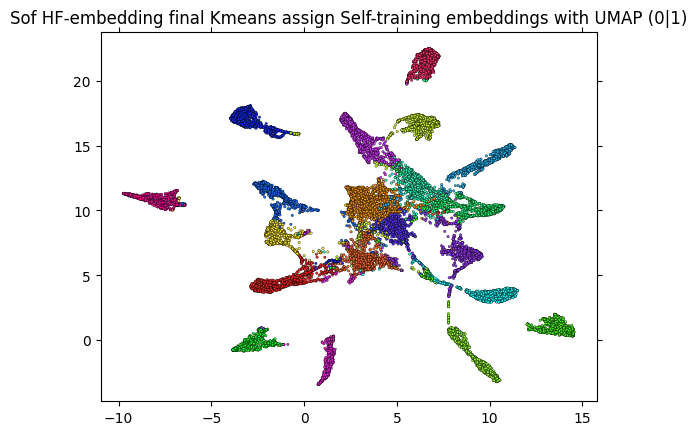

In [14]:
plot.commonSpace_plot(z.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred,
                      data_name="Sof HF-embedding final Kmeans assign", dimred = 'UMAP')

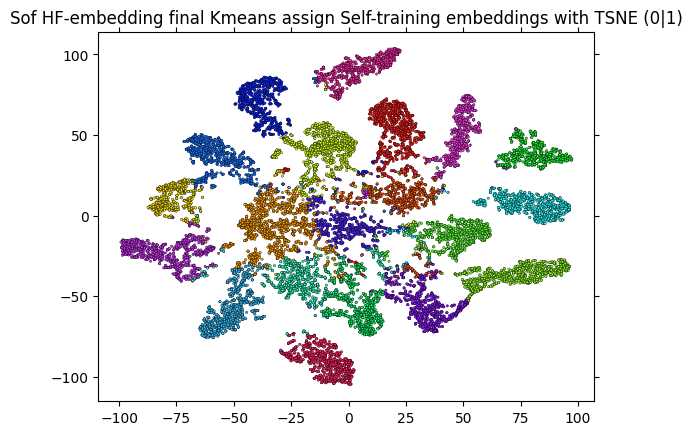

In [15]:
plot.commonSpace_plot(z.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred,
                      data_name="Sof HF-embedding final Kmeans assign", dimred = 'TSNE')

### STC-datstackoverflow-wdeHuggingFace-scaMinMax-tfeNone-normNone-initSphericalKmeans + Kmeans

In [16]:
stc_weights=join(data_in_dir, 
                 dataset, 
                 "artefacts",
                 "STC-datstackoverflow-wdeHuggingFace-scaMinMax-tfeNone-normNone-initSphericalKmeans.pth")

In [17]:
x, y = load_data(dataset=dataset_dir, word_emb='HuggingFace', transform=None, scaler='MinMax', norm=None)
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(stc_weights)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

MinMax scaling completed...


(torch.Size([18000, 384]),
 torch.Size([2000, 384]),
 torch.Size([18000]),
 torch.Size([2000]))

In [18]:
z2 = stc.autoencoder.encoder(X_train)

In [19]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_hf_mmx_ikm2 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(z2.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_hf_mmx_ikm2 = np.array(tmp)
np.round(avg_hf_mmx_ikm2.mean(axis=0), 3) * 100, avg_hf_mmx_ikm2.std(axis=0)

(array([70.6, 64.8, 56.3]), array([0.00010198, 0.00010198, 0.00017205]))

In [20]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
kmeans.fit(z2.detach().numpy())
y_km_pred2 = kmeans.labels_

In [21]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred2)

[0.7064, 0.6484, 0.5634]

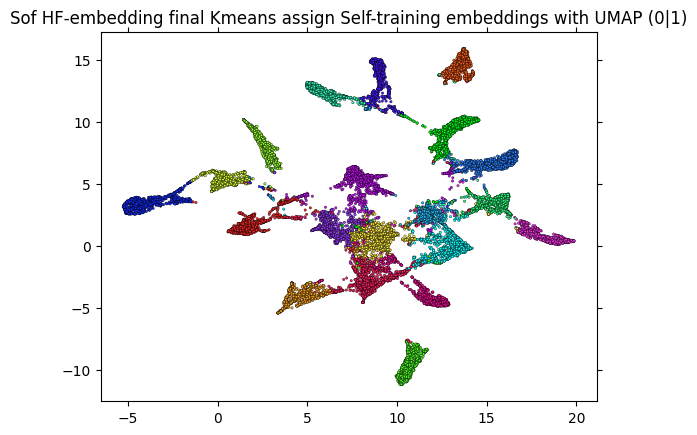

In [22]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred2,
                      data_name="Sof HF-embedding final Kmeans assign", dimred = 'UMAP')

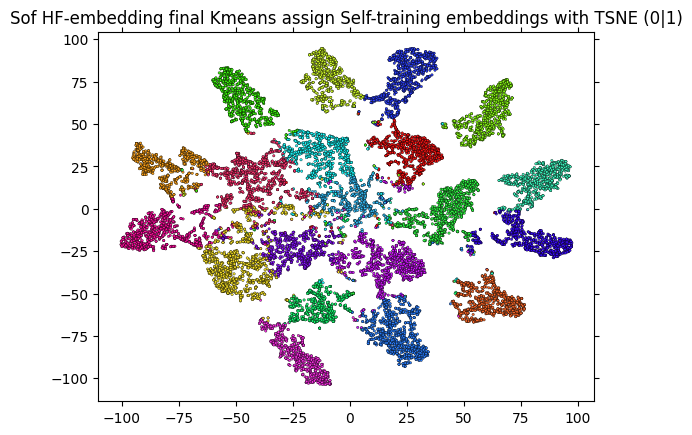

In [23]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred2,
                      data_name="Sof HF-embedding final Kmeans assign", dimred = 'TSNE')